In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import datasets, metrics, model_selection, svm
import statsmodels.api as sm
import shap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h4>Read in building and electical consumption data</H4>

In [79]:
# read in electricity consumption and building data
kwh_year_df = pd.read_csv('clean-data/kwh_year.csv')

In [4]:
kwh_year_df.head()

,Unnamed: 0,Service Address,avg_kwh,Latitude,Longitude,Parcel Number,prop_id,Effective_YrBlt,Heated_SquareFeet,Stories,kwh_per_sqft,code_release
0,0,2629 NW 55TH BLVD,726.077670,29.705149,-82.361609,6014021030,32391,1977,1498.0,1.0,0.484698,16
1,1,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004018000,78433,1984,2971.0,1.0,0.928601,18
2,2,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004018000,78433,1984,2971.0,1.0,0.928601,18
3,3,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004018000,78433,1984,2971.0,1.0,0.928601,18
4,4,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004017000,78432,2010,1222.0,2.0,2.257671,27


In [80]:
kwh_year_df = kwh_year_df.drop(columns='Unnamed: 0')

In [81]:
kwh_year_df = kwh_year_df.drop(columns=['Service Address'])

In [7]:
# # read in electricity consumption data
# electricity_df = pd.read_csv('data/GRU_Customer_Electric_Consumption.csv')

<h4>Identify colinear features</h4>

<h4>Remove colinear features</h4>

In [82]:
col_kwh_year_df = kwh_year_df.drop(columns=['prop_id', 'Parcel Number', 'Effective_YrBlt', 'Stories']) 
col_kwh_year_df.columns

Index(['avg_kwh', 'Latitude', 'Longitude', 'Heated_SquareFeet', 'kwh_per_sqft',
       'code_release'],
      dtype='object')

In [83]:
col_kwh_year_df.head()

,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft,code_release
0,726.077670,29.705149,-82.361609,1498.0,0.484698,16
1,2758.873786,29.679885,-82.353693,2971.0,0.928601,18
2,2758.873786,29.679885,-82.353693,2971.0,0.928601,18
3,2758.873786,29.679885,-82.353693,2971.0,0.928601,18
4,2758.873786,29.679885,-82.353693,1222.0,2.257671,27


<h4>Train, test split and instantiate linear regression models</h4>

In [65]:
# y1 = col_kwh_year_df.pop('code_release')
# X1 = col_kwh_year_df

In [66]:
# X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.25, random_state=1)

In [20]:
# y = col_kwh_year_df.pop('code_release')
# x = col_kwh_year_df

<h4>PCA</h4>

In [11]:
# # standardizing data
# features = ['avg_kwh', 'Latitude', 'Longitude', 'Parcel Number', 'Effective_YrBlt',
#        'Heated_SquareFeet', 'kwh_per_sqft']
# # Separating out the features
# x = col_kwh_year_df.loc[:, features].values
# # Separating out the target
# y = col_kwh_year_df.loc[:,['code_release']].values
# # Standardizing the features
# x = StandardScaler().fit_transform(x)

In [12]:
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['pc1', 'pc2', 'pc3'])

In [13]:
# finalDf = pd.concat([principalDf, col_kwh_year_df[['code_release']]], axis = 1)

In [14]:
# year_list = col_kwh_year_df['code_release'].values

In [15]:
# finalDf.head()

<h4>Define Target variable and feature set</h4>

In [84]:
y = col_kwh_year_df.pop('code_release')
X = col_kwh_year_df

<h4>Train, test split and instantiate linear regression models</h4>

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.50, random_state=1)

In [86]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5384 entries, 5884 to 10209
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_kwh            5384 non-null   float64
 1   Latitude           5384 non-null   float64
 2   Longitude          5384 non-null   float64
 3   Heated_SquareFeet  5384 non-null   float64
 4   kwh_per_sqft       5384 non-null   float64
dtypes: float64(5)
memory usage: 252.4 KB


In [40]:
# X_test = X_test.sort_index()
# X_test[:200]

<h4>Set benchmark model</h4>

In [67]:
alpha = 3.0
linear = LinearRegression()
lasso = Lasso()
ridge = Ridge(alpha=alpha)
knn = KNeighborsRegressor(7)

In [68]:
folds = 15
#score = mean_squared_error()
linear_cv = cross_val_score(linear, X, y, cv=folds, scoring='neg_mean_squared_error')
lasso_cv = cross_val_score(lasso, X, y, cv=folds, scoring='neg_mean_squared_error')
ridge_cv = cross_val_score(ridge, X, y, cv=folds, scoring='neg_mean_squared_error')
knn_cv = cross_val_score(knn1, X, y, cv=folds, scoring='neg_mean_squared_error')

In [69]:
lin_cv_mean = linear_cv.mean()
lasso_cv_mean = lasso_cv.mean()
ridge_cv_mean = ridge_cv.mean()
knn_cv_mean = knn_cv1.mean()


print(lin_cv_mean, lasso_cv_mean, ridge_cv_mean, knn_cv_mean)

-11.92922891037909 -12.133392446670138 -11.956216857917832 -14.640032693545402


<h4>Ordinary Least Squares</h4>

In [70]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.mse_total)
# print(est2.summary())

11.637038790448663


<h4>Run random forest regressor</h4>

In [87]:
# instantiate RF and linear regression model
rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
mse

8.050380351943598

#### Train top performing model on test set to generate predictions for Dash app

In [88]:
X_test2 = X_train 
y_test2 = y_train 

In [89]:
X_train.head()

,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft
6410,1027.639344,29.705515,-82.364586,1516.0,0.677862
4903,766.774510,29.612746,-82.371744,1172.0,0.654244
367,544.843137,29.611465,-82.360356,5944.0,0.091663
2448,1026.689320,29.675848,-82.384052,1684.0,0.609673
4206,500.291262,29.635181,-82.343227,1120.0,0.446689


In [90]:
rf_pred = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True)
rf_pred.fit(X_test2, y_test2)

RandomForestRegressor(max_depth=5, max_features=4, min_samples_split=5,
                      n_estimators=200)

In [92]:
y_hat_pred = rf_pred.predict(X_train)
# X_train.head()

In [105]:
y_hat_pred

,code_release_pred
0,18.151557
1,22.288971
2,20.192557
3,18.106214
4,18.989950
5,19.015050
6,20.288431
7,19.249870
8,20.145989
9,17.825421


In [107]:
# # convert predictions array into df
# y_hat_pred = pd.DataFrame({'code_release_pred': y_hat_pred[:]})

#### Run knn regressor

<h4>Check accuracy of predictions between train and test set</h4>

In [53]:
# X_test

In [52]:
# y_insamp_pred = rf.predict(X_test)

In [51]:
# # convert insample predictions array to df
# y_insamp_pred_df = pd.DataFrame({'col_1': y_insamp_pred[:] })

In [50]:
# y_insamp_pred_df.head()

In [49]:
# col_kwh_year_df[447:]

In [48]:
# y_insamp_pred.shape

In [47]:
# # convert X_test df into array
# X_test_arr = X_test.to_numpy()

# # scale back data to its original representation of x (array passed into train, test, split)
# x_test_inverse = X_test_arr.inverse_transform(y_insamp_pred)

In [54]:
# col_kwh_year_df

<h4>Generate Predictions for kwh consumption data</h4>

In [41]:
# 'avg_kwh', 'Latitude', 'Longitude', 'prop_id', 'Heated_SquareFeet',
#        'SHAPE_Area', 'kwh_per_sqft', 'code_release'

In [42]:
# electricity_df.info()

In [43]:
# # remove non numerical columns 
# electricity_df = electricity_df.drop(columns=['Service Address','Service City', 'Month', 'Year', 'Date', 'Location'])

In [44]:
# electricity_df = electricity_df.dropna()

In [45]:
# electricity_df.head()
# electricity_arr = electricity_df.to_numpy()

<h4>Scale input Data</h4>

In [46]:
# # standardizing data
# features_input = ['KWH Consumption', 'Latitude', 'Longitude']
# # Separating out the features
# x_input = electricity_df.loc[:, features_input].values
# # Standardizing the features
# x_input = StandardScaler().fit_transform(x_input)

In [47]:
# x_input[1]

#### Feature importance

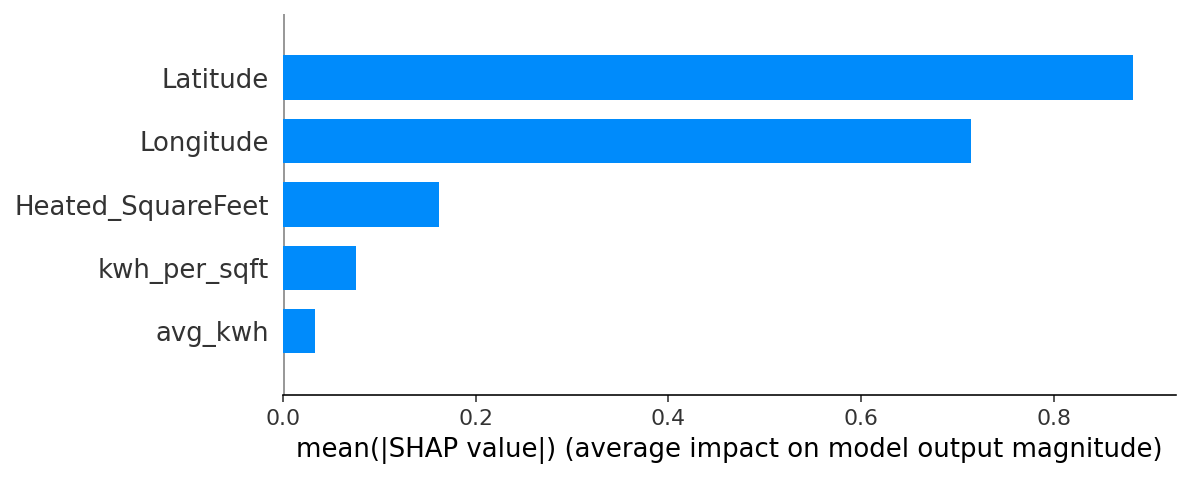

In [94]:
# rf 
shap_values = shap.TreeExplainer(rf_pred).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [95]:
# # knn
# knn_explainer = shap.KernelExplainer(knn4.predict,X_test)
# knn_shap_values = knn_explainer.shap_values(X_test)

In [97]:
# # knn
# f = plt.figure()
# shap.summary_plot(knn_shap_values, X_test)
# # f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

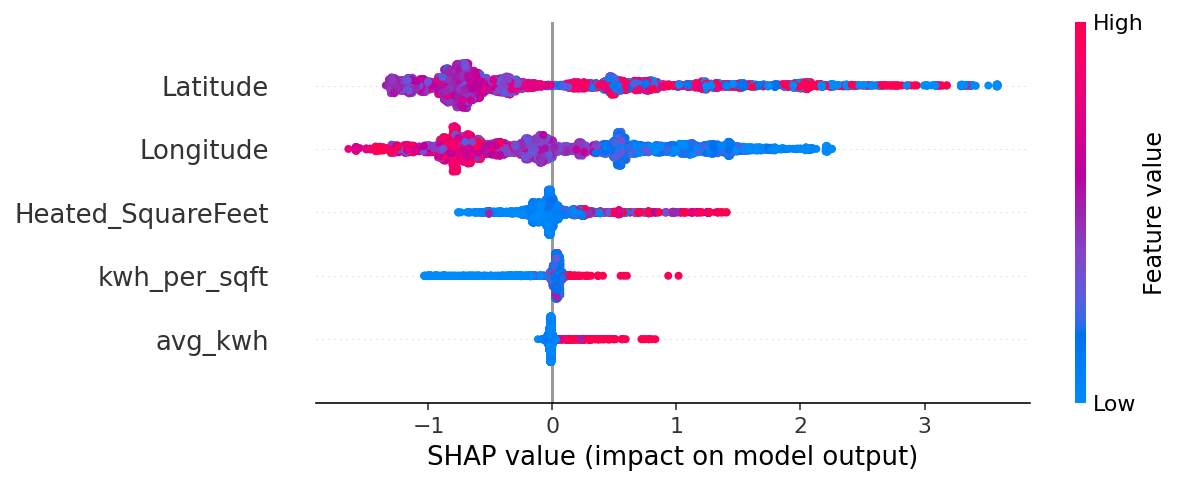

In [98]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train)
# f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

<h4>Generate efficiency investement index predictions df for test set for Dash</h4>

In [99]:
# y_hat_test = rf.predict(X_test)

In [100]:
# X_test_pred = X_test
# X_test_pred['pred_code_release'] = y_hat_test

In [101]:
# #8615

# X_test_pred.info()

<h4>Export predictions dataframe</h4>

In [109]:
y_hat_pred.head()

,code_release_pred
0,18.151557
1,22.288971
2,20.192557
3,18.106214
4,18.989950


In [108]:
# export predictions data for use in the carbon zero application
y_hat_pred.to_csv(r'stationary-data/y_hat_pred.csv', header=True)

In [110]:
# export training data to compare to predicted data 
# for efficiency val calc for prioritization of ee impr in Dash app
X_train.to_csv(r'stationary-data/X_train.csv', header=True)

In [112]:
# export y train for actual value in prediction feature engineering
# for efficiency val calc for prioritization of ee impr in Dash app
y_train.to_csv(r'stationary-data/y_train.csv', header=True)

In [111]:
# export training data to compare to predicted data 
# for efficiency val calc for prioritization of ee impr in Dash app
col_kwh_year_df.to_csv(r'stationary-data/col_kwh_year_df.csv', header=True)